# Testing performance of different 2D Feature detectors in OpenCV

Imports...

In [55]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import time

sn.set()

In [274]:
# Utilities
r2b = lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
r2ba = lambda x: cv2.cvtColor(x, cv2.COLOR_BGRA2RGBA)

## Create an artificial split image 

Read image

In [2]:
im = cv2.imread('full.jpg')

Find an overlapping horizontal (width) split at: 5/8 and 3/8.
E.g. the left image will end at 5/8 the width, and the right image will start at 3/8 the width.
This was the images will overlap in 2/8 or 1/4 of the width.

In [3]:
im.shape[1] * (5./8.), im.shape[1] * (3./8.)

(1617.5, 970.5)

Using the above information we split the image horizontally.

In [4]:
im_left = im[:,:1617]
im_right = im[:,970:]

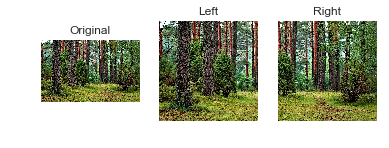

In [277]:
plt.subplot(131),plt.imshow(r2b(im)),plt.axis('off'),plt.title('Original')
plt.subplot(132),plt.imshow(r2b(im_left)),plt.axis('off'),plt.title('Left')
plt.subplot(133),plt.imshow(r2b(im_right)),plt.axis('off'),plt.title('Right');

In [7]:
h_orig,w_orig = im.shape[:2]
h,w = im_right.shape[:2]

## A feature-type-oblivious test

To measure the success of features we will need to change the feature types while keeping the same API.
Luckily this is easily possible in OpenCV.

The following function will provide us with a `cv2.Feature2D` feature detector for each algorithm as well as a `cv2.DetectorMatcher` to match the features.

In [278]:
# adapted from: https://github.com/opencv/opencv/blob/master/samples/python/find_obj.py
def init_feature(name):
    chunks = name.split('-')
    if chunks[0] == 'sift':
        detector = cv2.xfeatures2d.SIFT_create(2500)
        norm = cv2.NORM_L2
    elif chunks[0] == 'surf':
        detector = cv2.xfeatures2d.SURF_create(6500)
        norm = cv2.NORM_L2
    elif chunks[0] == 'orb':
        detector = cv2.ORB_create(2500)
        norm = cv2.NORM_HAMMING
    elif chunks[0] == 'akaze':
        detector = cv2.AKAZE_create(threshold=0.0065)
        norm = cv2.NORM_HAMMING
    elif chunks[0] == 'brisk':
        detector = cv2.BRISK_create(100)
        norm = cv2.NORM_HAMMING
    else:
        return None, None
    if 'flann' in chunks:
        FLANN_INDEX_KDTREE = 1
        FLANN_INDEX_LSH    = 6

        if norm == cv2.NORM_L2:
            flann_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        else:
            flann_params= dict(algorithm = FLANN_INDEX_LSH,
                               table_number = 6, # 12
                               key_size = 12,     # 20
                               multi_probe_level = 1) #2
        matcher = cv2.FlannBasedMatcher(flann_params, {})  # bug : need to pass empty dict (#1329)
    else:
        matcher = cv2.BFMatcher(norm)
    return detector, matcher

# A utility function to align feature points using the given matching, also apply the 2-NN ratio test
def filter_matches(kp1, kp2, matches, ratio = 0.75):
    mkp = [(kp1[m[0].queryIdx], kp2[m[0].trainIdx]) for m in matches if len(m) == 2 and m[0].distance < m[1].distance * ratio]
    mkp1,mkp2 = zip(*mkp)
    p1 = np.float32([kp.pt for kp in mkp1])
    p2 = np.float32([kp.pt for kp in mkp2])
    return p1, p2, mkp

Visualize some features

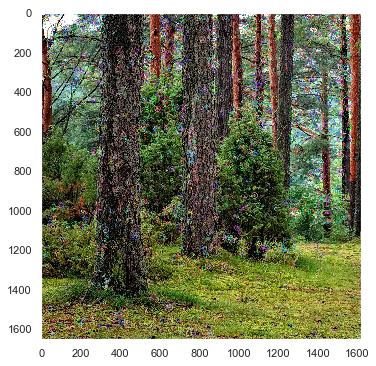

In [281]:
out = im_left.copy()

# get keypoints
detector, matcher = init_feature('surf-flann')
im_kpts, im_desc = detector.detectAndCompute(im_left, None)

cv2.drawKeypoints(out, im_kpts, out, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS+cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG)
plt.figure(figsize=(6,6))
plt.imshow(r2b(out)), plt.grid(False);

### Pre-cache the rotated images
In order to save time in the main loop, we will create the rotated images

In [244]:
num_stops = 19
w_r = int(np.sqrt(w*w+h*h)) # the diagonal of the image can serve as the width of the new images
h_r = int(np.sqrt(w*w+h*h)) # since a 45deg rotation will have the diagonal as width.
s_y,s_x = int(h_r/2-h/2),int(w_r/2-w/2) # offset for central-rotation

ims, masks = [],[]
for i,a in enumerate(np.linspace(-90,90,num_stops)):
    im_right_ext = np.ones((h_r,w_r,3), np.uint8) * 255 # white border...
    im_right_ext[s_y:s_y+h, s_x:s_x+w] = im_right # offset the image to the center
    im_right_mask = np.zeros((h_r,w_r,3), np.uint8) # a mask is also needed
    im_right_mask[s_y:s_y+h, s_x:s_x+w] = 255

    M = cv2.getRotationMatrix2D((w_r/2.0+0.5,h_r/2.0+0.5), a, 1.0) # rotate about the center
    ims += [cv2.warpAffine(im_right_ext, M, (w_r,h_r), borderValue=(255,255,255))]
    masks += [cv2.warpAffine(im_right_mask, M, (w_r,h_r))] # also rotate the mask...
    
    cv2.imwrite('rotations/%03d.jpg'%i, ims[-1])

The major test loop follows.

We will go through all feature types, extract the features for the left image and then for each of the rotated images. Then we match and align.

In [245]:
results = {}

In [246]:
for feature_name in ['akaze','surf','sift','orb','brisk']:
    # extract features for left image
    detector, matcher = init_feature(feature_name + '-flann')
    im_kpts, im_desc = detector.detectAndCompute(im_left, None)
    matcher.add([im_desc]) # cache the left features
    
    results[feature_name] = {'MSE': [], 'time': []}

    # loop the right image rotations
    for i,a in enumerate(np.linspace(-90,90,num_stops)):
        t = time.process_time()
        # extract features
        kpts,desc = detector.detectAndCompute(ims[i],masks[i][:,:,0])

        # match with the left image
        raw_matches = matcher.knnMatch(desc,k=2) #2
        p1, p2, _ = filter_matches(kpts, im_kpts, raw_matches) # align and filter
        
        results[feature_name]['time'].append(time.process_time() - t) # record execution time
        if len(p1) < 4:
            print('%d matches found, not enough for transform estimation' % len(p1))
            continue

        # recover the transformation (rotation + translation)
        H, status = cv2.estimateAffine2D(p1, p2, method=cv2.RANSAC, ransacReprojThreshold=5.0)
        p1, p2 = p1[status], p2[status]
        warped = cv2.warpAffine(ims[i], H, (w_orig,h_orig)) # undo th rotation on the right image
        warped_mask = cv2.warpAffine(masks[i], H, (w_orig,h_orig)) / 255.0
        
        # stitch the images using the mask
        stitched_out = np.zeros((h_orig,w_orig,3),np.uint8)
        stitched_out[:,:w-1] = im_left
        stitched_out = np.uint8(stitched_out * (1 - warped_mask)) + np.uint8(warped * warped_mask)

        # calculate the metrics
        MSE = np.mean((stitched_out-im)**2)
        results[feature_name]['MSE'].append(MSE)
        print('%s, angle= %d, %d / %d  inliers/matched, MSE = %.3f' % (feature_name, 
                                                                       int(a), 
                                                                       np.sum(status), 
                                                                       len(status), 
                                                                       MSE))

akaze, angle= -90, 1005 / 1034  inliers/matched, MSE = 7.382
akaze, angle= -80, 855 / 878  inliers/matched, MSE = 30.489
akaze, angle= -70, 811 / 835  inliers/matched, MSE = 31.352
akaze, angle= -60, 829 / 856  inliers/matched, MSE = 31.279
akaze, angle= -50, 828 / 861  inliers/matched, MSE = 31.555
akaze, angle= -40, 832 / 858  inliers/matched, MSE = 31.644
akaze, angle= -30, 822 / 842  inliers/matched, MSE = 30.807
akaze, angle= -20, 819 / 855  inliers/matched, MSE = 30.096
akaze, angle= -10, 860 / 886  inliers/matched, MSE = 29.946
akaze, angle= 0, 1106 / 1129  inliers/matched, MSE = 6.745
akaze, angle= 10, 862 / 889  inliers/matched, MSE = 30.566
akaze, angle= 20, 812 / 842  inliers/matched, MSE = 31.245
akaze, angle= 30, 836 / 867  inliers/matched, MSE = 31.539
akaze, angle= 40, 833 / 856  inliers/matched, MSE = 32.106
akaze, angle= 50, 833 / 859  inliers/matched, MSE = 31.212
akaze, angle= 60, 824 / 848  inliers/matched, MSE = 30.518
akaze, angle= 70, 826 / 857  inliers/matched, 

In [247]:
from scipy.interpolate import make_interp_spline, BSpline

## Charting the results

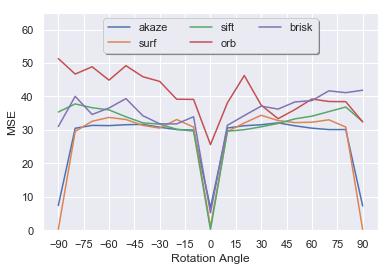

In [266]:
xold = np.linspace(-90,90,num_stops)
for f in results:
    plt.plot(xold,results[f]['MSE'],label=f)
plt.legend(loc='upper center',ncol=3,fancybox=True, shadow=True)
plt.ylim(0,65),plt.xticks(np.linspace(-90,90,13).astype(np.int))
plt.ylabel('MSE'),plt.xlabel('Rotation Angle')
plt.savefig('rotation_perf.svg')

In [250]:
times = [np.mean(results[r]['time']) for r in results]
mses = [np.mean(results[r]['MSE']) for r in results]

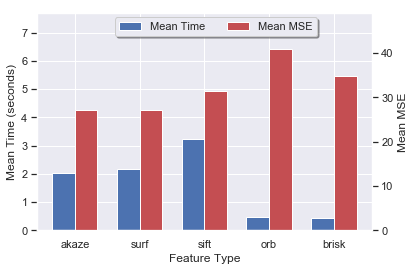

In [267]:
fig = plt.figure()
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

indices = np.arange(len(results))
width = 0.35

ax.bar(indices - width/2, times, width = width, color='b', label='Mean Time')
ax.set_label('Maan Time')
ax.set_ylabel('Mean Time (seconds)')
ax.set_xlabel('Feature Type')
ax.set_ylim(0,7.7)
ax.axes.set_xticklabels([0]+list(results.keys()))

ax2.bar(indices + width/2, mses, width = width, color='r', label='Mean MSE')
ax2.set_ylabel('Mean MSE')
ax2.grid(None)
ax2.set_ylim(0,49)

fig.legend(loc='upper center', ncol=2,fancybox=True, shadow=True, bbox_to_anchor=(0.5,0.9))
plt.savefig('time_vs_mse.svg')

At this point we can decide on the best feature type for the job.

In this case it seems AKAZE is the best performer.